In [1]:
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


pd.set_option('display.max_rows', None)

In [2]:
# Reading data files

# Fundamental Stocks is the data file I created from compiling Fundamental Data from EODHD including GICS info and other stuff
gic = pd.read_csv('data/CompiledStock.csv')

# Latest Super is the supplied data file which includes the superfund asset information 
assets = pd.read_excel('data/Latest Super.xlsx', sheet_name='Dataset')

In [3]:
assets.isna().sum()

Super Fund Name                                                                                       0
Investment Option                                                                                     0
Asset Class\nOnly Listed Equities (Stocks, Shares) no other Asset Class and no Unlisted Equities    325
Asset Name                                                                                            8
Dollar Value\nThe Dollar Amount / Value of that Investement                                           0
dtype: int64

In [4]:
assets[assets['Asset Name'].isna()]

,Super Fund Name,Investment Option,"Asset Class\nOnly Listed Equities (Stocks, Shares) no other Asset Class and no Unlisted Equities",Asset Name,Dollar Value\nThe Dollar Amount / Value of that Investement
152,Retirement Wrap (BT),Active International Shares,Equity,NaN,2.980226e+08
6606,LGIAsuper,Indexed Balanced,Equity,NaN,1.718398e+07
7141,LGIAsuper,Indexed Balanced,Equity,NaN,1.592974e+07
8699,Retirement Wrap (BT),Active International Shares,Equity,NaN,1.304594e+07
10057,Retirement Wrap (BT),Active International Shares,Equity,NaN,1.120772e+07
20951,Retirement Wrap (BT),Active International Shares,Equity,NaN,4.966086e+06
74385,caresuper,Australian Shares,Listed Equity,NaN,9.703854e+05
89257,caresuper,Australian Shares,Listed Equity,NaN,7.389649e+05


In [5]:
#gic.head()

In [6]:
#assets.head()

### Creating the TF-IDF Matching Function

In [7]:
# Define the TF-IDF vectorizer and matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(gic['Company Name'])


# 'BER' 'DUS' 'HAM' 'MUN' 'STU' 'XETRA' 'LSE' removed due to incorrect GICS info

# Sets a priority for the matching function, will iteratively search for the best match starting with NASDAQ

selectExchange = ['NASDAQ', 'NYSE','ASX','SHE','EPA','AMS','ATH','BUE','BKK','BRU','BDP','COL','CPH','DSE',
                  'FRA','HAN','HEL','ISM','IL','DUB','IST','JKT','JSE','KAR','KLSE','KRX','KOSDAQ','LIM',
                  'ELI','LUSE','BME','MCX','MSE','BMV','NEO','OSL','PRG','PSE','BSE','BVMF','SEM','SHG','SSE',
                  'TASI','STO','SWX','TLV','TSE','TPE','TWO','TSX','VIE','VSE','WSE','ZSE', 'NSE','NYSE ARCA', 
                  'NYSE MKT', 'OTCQX', 'OTCCE','OTCGREY','OTCMKTS','OTCQB']

# Function is used to match asset names from Latest Super and Fundamental Stocks using tfidf vectorizer
# I am not 100% sure on how it works but it transforms the company names from both datasets and determines similarity

def find_best_match(asset_row, gic_df, tfidf_vectorizer, tfidf_matrix, priority_order=selectExchange):
    
    asset_name = asset_row['Asset Name']
    
    # Do not perform matching if there is no asset name
    if pd.isnull(asset_name):    
        return asset_row
    
    best_match_company_details = None
    best_match_accuracy = 0.0
    
    for exchange in priority_order:
        
        # Filter the 'gic' DataFrame based on the exchange
        exchange_df = gic_df[gic_df['Exchange Ticker'] == exchange]
        
        # Sets a threshold to perform matching if the accuracy is less than 
        if best_match_accuracy < 0.8:
            if not exchange_df.empty:
                
            # Store the original index
                original_index = exchange_df.index
            
            # Reset the index of the filtered DataFrame
                exchange_df = exchange_df.reset_index(drop=True)
            
            # Transform the asset name into a TF-IDF vector
                asset_vector = tfidf_vectorizer.transform([asset_name])
            
            # Calculate cosine similarities between the asset vector and all company vectors
                similarities = cosine_similarity(asset_vector, tfidf_matrix[original_index])
                
            # Find the index of the most similar company within the filtered DataFrame
                best_match_index = exchange_df.index[similarities.argmax()]
            
            # Get all columns for the corresponding company using the original index
                current_match_company_details = gic_df.loc[original_index[best_match_index], :]
            
            # If the current match has a higher accuracy, update the best match
                if similarities[0, best_match_index] > best_match_accuracy:
                    best_match_company_details = current_match_company_details
                    best_match_accuracy = similarities[0, best_match_index]
    
    # Combine information from 'assets' and 'gic' DataFrames
    result_row = pd.concat([asset_row, best_match_company_details])
    result_row['Accuracy'] = best_match_accuracy
    
    return result_row



### Running the Function

In [8]:
import pandas as pd
import os

# Assuming you have a DataFrame named 'assets' and the 'find_best_match' function is defined

# Set the chunk size (number of rows to process in each iteration)
chunk_size = 200

# Set the path for the master file
master_file_path = "master_results3.xlsx"

# Initialize a variable to keep track of the starting index
start_index = 0  #47000
index = start_index
# Check if the master file already exists
if os.path.exists(master_file_path):
    # Load the existing master file
    master_results = pd.read_excel(master_file_path)
else:
    # If the master file doesn't exist, create an empty DataFrame
    master_results = pd.DataFrame()


    
# Continue processing as long as there are rows left in the current chunk
while start_index < chunk_size + index:
    # Get the chunk of the DataFrame
    chunk = assets.iloc[start_index:start_index + chunk_size]
    
    # Apply the find_best_match function to the chunk
    chunk_results = chunk.apply(lambda row: find_best_match(row, gic, tfidf_vectorizer, tfidf_matrix), axis=1)
    
    # Append the results to the master results
    master_results = master_results.append(chunk_results, ignore_index=True)
    
    # Update the starting index for the next iteration
    start_index += chunk_size

master_results = master_results.reindex(columns = ['Super Fund Name', 'Investment Option', 'Asset Class\nOnly Listed Equities (Stocks, Shares) no other Asset Class and no Unlisted Equities',
                                         'Asset Name', 'Dollar Value\nThe Dollar Amount / Value of that Investement', 'Accuracy', 'Company Name', 'Stock Ticker',  'Exchange Ticker', 'Exchange Name',
                                         'CountryName', 'ISIN', 'Description', 'SectorCode', 'Sector', 'IndustryGroupCode', 'IndustryGroup', 'IndustryCode', 'Industry', 'SubIndustryCode', 
                                         'SubIndustry', 'RatingDate'])
# Save the master results to an Excel file
master_results.to_excel(master_file_path, index=False)


C:\Users\josia\AppData\Local\Temp\ipykernel_26628\2911238288.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_results = master_results.append(chunk_results, ignore_index=True)


In [9]:
# import pandas as pd
# import os

# # Assuming you have a DataFrame named 'assets' and the 'find_best_match' function is defined

# # Set the total number of rows in the DataFrame
# total_rows = len(assets)

# # Set the chunk size (number of rows to process in each iteration)
# chunk_size = 10

# # Set the path for the master file
# master_file_path = "master_results.xlsx"

# # Initialize a variable to keep track of the starting index
# start_index = 0

# # Check if the master file already exists
# if os.path.exists(master_file_path):
#     # Load the existing master file
#     master_results = pd.read_excel(master_file_path)
# else:
#     # If the master file doesn't exist, create an empty DataFrame
#     master_results = pd.DataFrame()

# # Initialize an empty list to store the new results
# new_results = []

# # Iterate through chunks of the DataFrame
# while start_index < total_rows:
#     # Get the chunk of the DataFrame
#     chunk = assets.iloc[start_index:start_index + chunk_size]
    
#     # Apply the find_best_match function to the chunk
#     chunk_results = chunk.apply(lambda row: find_best_match(row, gic, tfidf_vectorizer, tfidf_matrix), axis=1)
    
#     # Append the results to the list
#     new_results.append(chunk_results)
    
#     # Update the starting index for the next iteration
#     start_index += chunk_size

# # Concatenate the new results into a single DataFrame
# new_results_df = pd.concat(new_results, ignore_index=True)

# # Append the new results to the existing master file
# master_results = master_results.append(new_results_df, ignore_index=True)

# master_results = master_results.reindex(columns = ['Super Fund Name', 'Investment Option', 'Asset Class\nOnly Listed Equities (Stocks, Shares) no other Asset Class and no Unlisted Equities',
#                                          'Asset Name', 'Dollar Value\nThe Dollar Amount / Value of that Investement', 'Accuracy', 'Company Name', 'Stock Ticker',  'Exchange Ticker', 'Exchange Name',
#                                          'CountryName', 'ISIN', 'Description', 'SectorCode', 'Sector', 'IndustryGroupCode', 'IndustryGroup', 'IndustryCode', 'Industry', 'SubIndustryCode', 
#                                          'SubIndustry', 'RatingDate'])
# # Save the updated master file
# master_results.to_excel(master_file_path, index=False)


In [10]:
master_results['Exchange Ticker'].unique()

array(['ASX', 'NYSE ARCA', 'NASDAQ', 'BMV', 'NYSE', 'TSX', 'SWX', 'FRA',
       'KRX', 'TWO', 'TSE', 'SHG', nan, 'NSE', 'BKK', 'KLSE', 'WSE',
       'EPA'], dtype=object)

In [11]:
master_results.describe()

,Dollar Value\nThe Dollar Amount / Value of that Investement,Accuracy,SectorCode,IndustryGroupCode,IndustryCode,SubIndustryCode,RatingDate
count,2.000000e+02,199.000000,199.000000,199.000000,199.000000,1.990000e+02,0.0
mean,4.785435e+08,0.791650,31.557789,3170.753769,317098.849246,3.170990e+07,NaN
std,2.885741e+08,0.219178,13.774351,1380.053042,138000.716667,1.380007e+07,NaN
min,2.615411e+08,0.148732,10.000000,1010.000000,101020.000000,1.010202e+07,NaN
25%,3.000230e+08,0.603637,15.000000,1510.000000,151040.000000,1.510402e+07,NaN
50%,3.757951e+08,0.868626,40.000000,4010.000000,401010.000000,4.010101e+07,NaN
75%,5.067015e+08,1.000000,40.000000,4020.000000,402030.000000,4.020301e+07,NaN
max,1.774062e+09,1.000000,60.000000,6020.000000,602010.000000,6.020103e+07,NaN


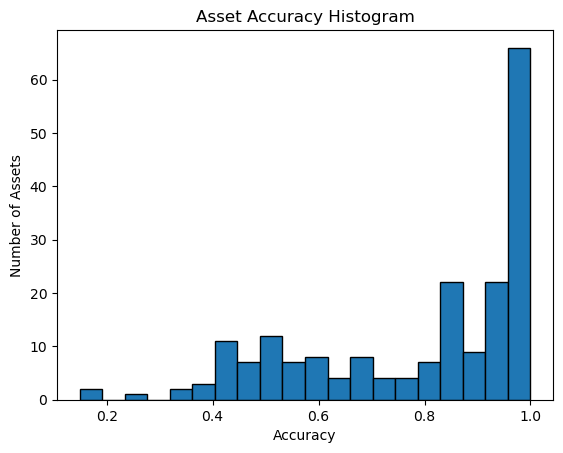

In [12]:
plt.hist(master_results["Accuracy"], bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel("Accuracy")
plt.ylabel("Number of Assets")
plt.title("Asset Accuracy Histogram")
plt.show()
